In [1]:
import pandas as pd
import matplotlib.pyplot as plt, matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn import svm
import os, PIL
import numpy as np
from skimage.io import imread
from glob import glob
from tqdm import tqdm 

In [2]:
# GLOBALS
seed = 69 
np.random.seed(seed)
NUM_CLASSES = 10 
NUM_EXAMPLES = 42000
KEEP_NUM = 10000
HEIGHT = 28
WIDTH = 28

def load_data(file_path='data/', keep_num=KEEP_NUM):
    x, y = np.zeros((NUM_EXAMPLES, HEIGHT, WIDTH), dtype=np.float32), np.zeros(NUM_EXAMPLES, dtype=np.uint8)
    img_num = 0
    for label in tqdm(range(NUM_CLASSES)):
        class_img_paths = glob(os.path.join(file_path, str(label), '*.jpg')) 
        for img_path in class_img_paths:
            # This will bring the data to between 0. and 1. (makes machine learning models easier to train)
            x[img_num] = imread(img_path, as_grey=True) / 255.
            y[img_num] = label
            img_num += 1
            
    random_idxs = np.random.permutation(NUM_EXAMPLES)
    x = x[random_idxs[:keep_num]]
    y = y[random_idxs[:keep_num]]
            
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=seed, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed, stratify=y_train)        
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# PIPELINE STEP 1: LOAD AND ANALYZE DATA

Normally to perform supervised learning you need two types of data sets:

* In one dataset (your "gold standard") you have the input data together with correct/expected output, This dataset is usually duly prepared either by humans or by collecting some data in semi-automated way. But it is important that you have the expected output for every data row here, because you need for supervised learning.
* The data you are going to apply your model to. In many cases this is the data where you are interested for the output of your model and thus you don't have any "expected" output here yet.

While performing machine learning you do the following:

* Training phase: you present your data from your "gold standard" and train your model, by pairing the input with expected output.
* Validation/Test phase: in order to estimate how well your model has been trained (that is dependent upon the size of your data, the value you would like to predict, input etc) and to estimate model properties (mean error for numeric predictors, classification errors for classifiers, recall and precision for IR-models etc.)
* Application phase: now you apply your freshly-developed model to the real-world data and get the results. Since you normally don't have any reference value in this type of data (otherwise, why would you need your model?), you can only speculate about the quality of your model output using the results of your validation phase.

The validation phase is often split into two parts:

* In the first part you just look at your models and select the best performing approach using the validation data (=validation)
* Then you estimate the accuracy of the selected approach (=test).
Hence the separation to 50/25/25.

In case if you don't need to choose an appropriate model from several rivaling approaches, you can just re-partition your set that you basically have only training set and test set, without performing the validation of your trained model. I personally partition them 70/30 then.

Check out [this question](https://stats.stackexchange.com/questions/9357/why-only-three-partitions-training-validation-test) for more information. 



In [3]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_data()
NUM_TRAIN = len(X_train)
NUM_VAL = len(X_val)
NUM_TEST = len(X_test)

100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


## Viewing an Image

* Since the image is currently one-dimension, we load it into a numpy array and reshape it so that it is two-dimensional (28x28 pixels)
* Then, we plot the image and label with matplotlib

**You can change the value of variable i to check out other images and labels**

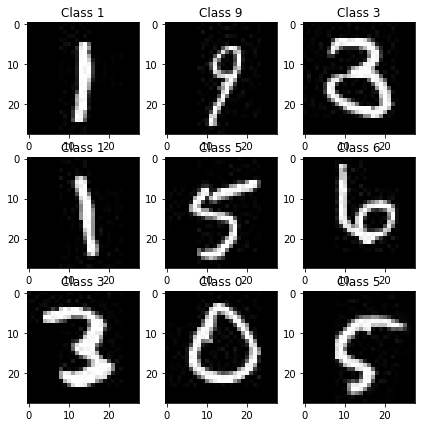

In [4]:
i = 0

plt.figure(figsize=(7, 7))
for image_idx in range(i, i + 9):
    plt.subplot(3, 3, image_idx + 1)
    plt.imshow(X_train[image_idx], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[image_idx]))
plt.show()

## Examining the Pixel Values
**Note that these images aren't actually black and white (0,1). They are gray-scale (0-255).**

A [histogram](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hist) of this image's pixel values shows the range.

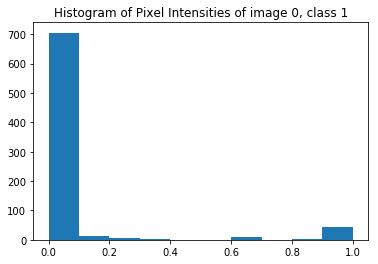

In [5]:
plt.hist(X_train[i].ravel())
plt.title('Histogram of Pixel Intensities of image {}, class {}'.format(i, y_train[i]))
plt.show()

# PIPELINE STEP 2: CREATE MODEL - START SIMPLE

## Training our model
* First, we use the [sklearn.svm](http://scikit-learn.org/stable/modules/svm.html#svc) module to create a [vector classifier](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).
* Next, we pass our training images and labels to the classifier's fit method, which trains our model.
* Finally, the test images and labels are passed to the score method to see how well we trained our model. Fit will return a float between 0-1 indicating our accuracy on the test data set

### Aside on SVM's (if you don't know what they are)
We have 2 colors of balls on the table that we want to separate.
![](http://i.imgur.com/zDBbD.png)

We get a stick and put it on the table, this works pretty well right?

![](http://i.imgur.com/aLZlG.png)

Some villain comes and places more balls on the table, it kind of works but one of the balls is on the wrong side and there is probably a better place to put the stick now. What a troll. 

![](http://i.imgur.com/kxWgh.png)

SVMs try to put the stick in the best possible place by having as big a gap on either side of the stick as possible. 

![](http://i.imgur.com/ePy4V.png)

Now when the villain returns, the stick is still in a pretty good spot.

![](http://i.imgur.com/BWYYZ.png)

There is another trick in the SVM toolbox that is even more important. Say the villain has seen how good you are with a stick so he gives you a new challenge.

![](http://i.imgur.com/R9967.png)

There’s no stick in the world that will let you split those balls well, so what do you do? You flip the table of course! Throwing the balls into the air. Then, with your pro ninja skills, you grab a sheet of paper and slip it between the balls.

![](http://i.imgur.com/WuxyO.png)

Now, looking at the balls from where the villain is standing, they balls will look split by some curvy line.

![](http://i.imgur.com/gWdPX.png)

Boring people the call balls data, the stick a classifier, the biggest gap trick optimization, call flipping the table kernelling and the piece of paper a hyperplane.

# PIPELINE STEP 2.1: TRAIN MODEL 

In [6]:
%%timeit -n 1 -r 1
clf = svm.SVC(C=1.0, kernel='rbf', degree=1)
clf.fit(X_train.reshape((NUM_TRAIN, -1)), y_train.ravel())
score = clf.score(X_val.reshape((NUM_VAL, -1)), y_val.ravel())
print('SVC score {}'.format(score))

SVC score 0.925
10.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# PIPELINE STEP 2.2: EVALUATE MODEL

### Analysis: How did our model do?

**You should have gotten around 0.92, or 92% accuracy. This is pretty good. 10% accuracy is what you would've gotten if you didn't divide the images by 255 (that is as good as randomly guessing a number).** 

### TODO:
Try playing with the parameters of svm.SVC (C, kernel type, degree, etc.) to see how the results change. Check out the SVC [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) for more info. 

**You should be able to do MUCH MUCH MUCH better by switching the parameters. Focus on the kernel type and degree ;) **


There are many ways to improve this, including not using a vector classifier, but here's a simple one to start. Let's just simplify our images by making them true black and white.
* To make this easy, any pixel with a value simply becomes 1 and everything else remains 0.
* We'll plot the same image again to see how it looks now that it's black and white. Look at the histogram now.

# PIPELINE STEP 2.3: ITERATE as necessary (feature engineering, model engineering, etc.)

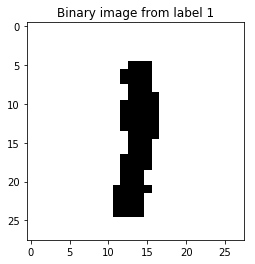

In [7]:
X_bin_test = np.where(X_test > 0.1, 1, 0) 
X_bin_val = np.where(X_val > 0.1, 1, 0)
X_bin_train = np.where(X_train > 0.1, 1, 0) 
 

img = X_bin_train[i]
plt.imshow(img, cmap='binary')
plt.title('Binary image from label {}'.format(y_train[i]))
plt.show()

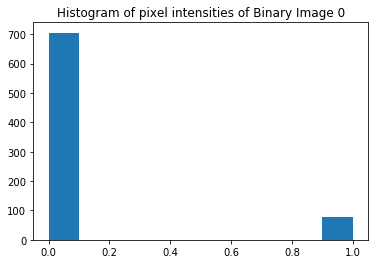

In [8]:
plt.title('Histogram of pixel intensities of Binary Image {}'.format(i))
plt.hist(img.ravel())
plt.show()

### Retraining our model

We follow the same procedure as before, but now our training and test sets are black and white instead of gray-scale. Our score still isn't great, but it's a huge improvement.

In [9]:
clf = svm.SVC(C=1.0, kernel='rbf', degree=1)

clf.fit(X_bin_train.reshape((NUM_TRAIN, -1)), y_train.ravel())
score = clf.score(X_bin_val.reshape((NUM_VAL, -1)), y_val.ravel())
print('SVC score {}'.format(score))

SVC score 0.934


# PIPELINE STEP 3: GET FINAL MODEL PERFORMANCE 

### Labelling the test data

Now for those making competition submissions (or just any final evaluation), we can load and predict the unlabeled data from the withheld test set. We then output this data to a results.csv. This will allow us to see how well our trained model performs on the final test set. 

In [10]:
predicted_classes = clf.predict(X_bin_test.reshape(NUM_TEST, -1))
svc_acc = np.mean(predicted_classes == y_test) * 100
print('Final test accuracy: {}%'.format(svc_acc))

Final test accuracy: 91.46%


### Visualizing Outputs

In [11]:
# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

CORRECTLY CLASSIFIED EXAMPLES


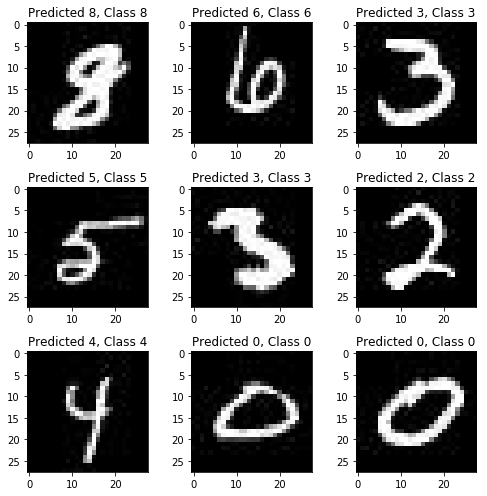

INCORRECTLY CLASSIFIED EXAMPLES


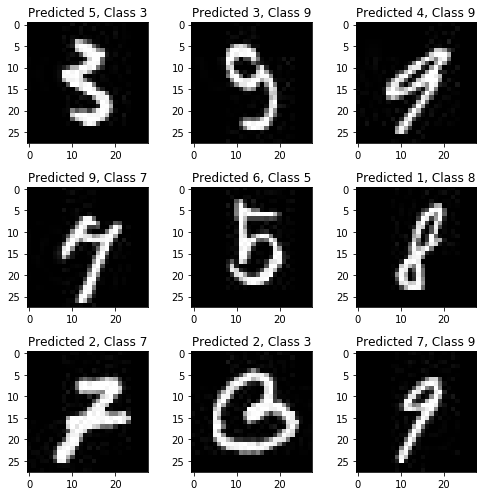

In [12]:
def show_outputs(correct_indices, incorrect_indices):
    print('CORRECTLY CLASSIFIED EXAMPLES')
    fig = plt.figure(figsize=(7,7))
    for i, correct in enumerate(correct_indices[:9]):
        plt.subplot(3,3,i+1)
        plt.imshow(X_test[correct], cmap='gray', interpolation='none')
        plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))    
    plt.tight_layout()
    plt.show() 
    
    print('INCORRECTLY CLASSIFIED EXAMPLES')
    plt.figure(figsize=(7,7))
    for i, incorrect in enumerate(incorrect_indices[:9]):
        plt.subplot(3,3,i+1)
        plt.imshow(X_test[incorrect], cmap='gray', interpolation='none')
        plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    plt.tight_layout()
    plt.show()
    
show_outputs(correct_indices, incorrect_indices)

# So, I think we can do better. Let's return to step 2, but with something more complicated: DEEP LEARRRRNNIIINNGGGGG

Check out some of these cool resources
1. https://www.youtube.com/watch?v=P2HPcj8lRJE
2. https://www.youtube.com/watch?v=h3l4qz76JhQ

![](https://memegenerator.net/img/instances/74873992/let-me-sprinkle-some-deep-learning-magic.jpg)

In [13]:
# Import goodies 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras.optimizers import SGD
from keras.utils import to_categorical 

Using TensorFlow backend.


Modify the target matrices to be in the one-hot format, i.e. ,

``` 
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0] 
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0] 
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0] 
etc. 
``` 

In [14]:
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_val_cat = to_categorical(y_val, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

### Build the neural network
Build the neural-network. Here we'll do a simple 3 layer fully connected network.
![](https://raw.githubusercontent.com/wxs/keras-mnist-tutorial/8824b7b56963a92ef879f09acd99cf3a210db2b8/figure.png)

In [15]:
model = Sequential()
model.add(Reshape((HEIGHT*WIDTH,), input_shape=(HEIGHT, WIDTH))) # Input image, flatten the image
model.add(Dense(512))
model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.
                           
model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax')) # This special "softmax" activation among other things,
                                 # ensures the output is a valid probaility distribution, that is
                                 # that its values are all non-negative and sum to 1.

### Compile the model
Keras is built on top of some backend (you should use [Tensorflow](https://www.tensorflow.org/)), which will be a backend that allow you to define a computation graph in Python, which they then compile and run efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiling a model, Keras asks you to specify your loss function and your optimizer. The loss function we'll use here is called categorical crossentropy, and is a loss function well-suited to comparing two probability distributions.

Here our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. More detail at Wikipedia

The optimizer helps determine how quickly the model learns, how resistent it is to getting "stuck" or "blowing up". We won't discuss this in too much detail, but "adam" is often a good choice. 

### TODO: Try messing with the parameters:
1. Number of Dense neurons 
2. Number of layers
2. Dropout parameters
3. [Activations](https://keras.io/activations/)
4. [Optimizer](https://keras.io/optimizers/)
5. Batch size
6. Number of epochs
7. Go crazy! (you probably don't need to for this dataset...) 

In [16]:
optim = 'adam'

model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

## Time to train! :D

In [17]:
# Why do we train on bin? Play around and see if you can do better. 
num_epochs = 10
batch_size = 32

fit = model.fit(X_train, y_train_cat,
          batch_size=batch_size, 
          epochs=num_epochs, verbose=1,
          validation_data=(X_val, y_val_cat))

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 1s 307us/step - loss: 0.6524 - acc: 0.8003 - val_loss: 0.2381 - val_acc: 0.9260
Epoch 2/10
4000/4000 [==============================] - 1s 209us/step - loss: 0.2474 - acc: 0.9245 - val_loss: 0.1906 - val_acc: 0.9360
Epoch 3/10
4000/4000 [==============================] - 1s 204us/step - loss: 0.1701 - acc: 0.9467 - val_loss: 0.1451 - val_acc: 0.9510
Epoch 4/10
4000/4000 [==============================] - 1s 224us/step - loss: 0.1186 - acc: 0.9635 - val_loss: 0.1541 - val_acc: 0.9560
Epoch 5/10
4000/4000 [==============================] - 1s 237us/step - loss: 0.0789 - acc: 0.9742 - val_loss: 0.1905 - val_acc: 0.9460
Epoch 6/10
4000/4000 [==============================] - 1s 228us/step - loss: 0.0600 - acc: 0.9802 - val_loss: 0.1701 - val_acc: 0.9500
Epoch 7/10
4000/4000 [==============================] - 1s 258us/step - loss: 0.0450 - acc: 0.9845 - val_loss: 0.1677 - val_acc: 0.9590


In [18]:
def plot_val_train(metrics, fit):
    plt.figure(figsize=(14,3))
    for i, m in enumerate(metrics):
        train_measure = fit.history[m]
        val_measure = fit.history["val_" + m]
        eps = np.arange(len(train_measure))

        plt.subplot(1, 2, i + 1)
        plt.plot(eps, train_measure, '-r', label='Training ' + m)
        plt.plot(eps, val_measure, '-b', label='Validation ' + m)
        plt.legend(loc='lower right')
    plt.show()

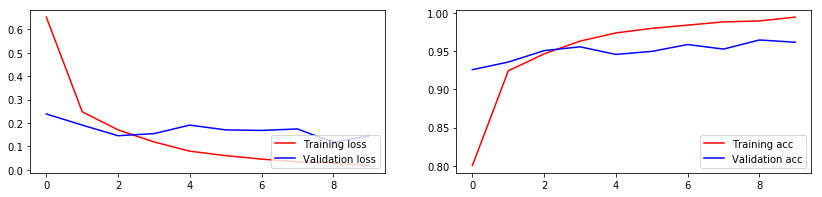

In [19]:
plot_val_train(['loss', 'acc'], fit)

![](http://cs231n.github.io/assets/nn3/accuracies.jpeg)
The gap between the training and validation accuracy indicates the amount of overfitting. Two possible cases are shown in the diagram above. The blue validation error curve shows very small validation accuracy compared to the training accuracy, indicating strong overfitting (note, it's possible for the validation accuracy to even start to go down after some point). When you see this in practice you probably want to increase regularization (stronger L2 weight penalty, more dropout, etc.) or collect more data. The other possible case is when the validation accuracy tracks the training accuracy fairly well. This case indicates that your model capacity is not high enough: make the model larger by increasing the number of parameters.

** What does this mean for your generated train/validation accuracy?**

Overfitting occurs when a statistical model or machine learning algorithm captures the noise of the data.  Intuitively, overfitting occurs when the model or the algorithm fits the data too well.  Specifically, overfitting occurs if the model or algorithm shows low bias but high variance.  Overfitting is often a result of an excessively complicated model, and it can be prevented by fitting multiple models and using validation or cross-validation to compare their predictive accuracies on test data.

Underfitting occurs when a statistical model or machine learning algorithm cannot capture the underlying trend of the data.  Intuitively, underfitting occurs when the model or the algorithm does not fit the data well enough.  Specifically, underfitting occurs if the model or algorithm shows low variance but high bias.  Underfitting is often a result of an excessively simple model.

Both overfitting and underfitting lead to poor predictions on new data sets.

In [20]:
loss, acc = model.evaluate(X_test, y_test_cat, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', acc)

5000/5000 [==============================] - 0s 57us/step
Test loss: 0.225407455571
Test accuracy: 0.9474


In [21]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_probs = model.predict(X_bin_test)
predicted_classes = np.argmax(predicted_probs, axis=-1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

CORRECTLY CLASSIFIED EXAMPLES


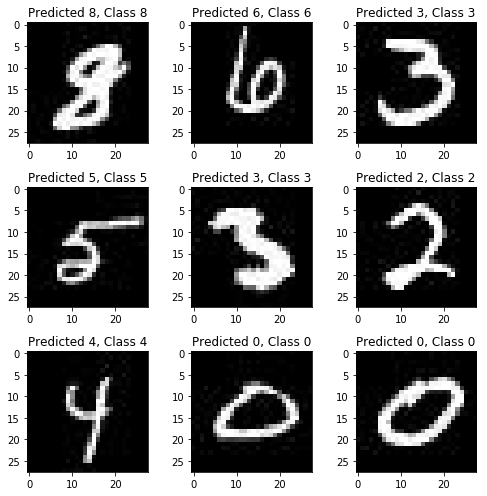

INCORRECTLY CLASSIFIED EXAMPLES


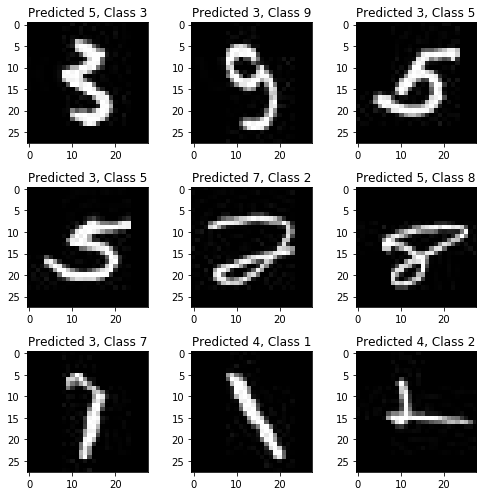

In [22]:
show_outputs(correct_indices, incorrect_indices)

In [23]:
print('SVM Final test accuracy: {}'.format(svc_acc))
print('Neural Net Final test accuracy: {}'.format(acc*100))

SVM Final test accuracy: 91.46
Neural Net Final test accuracy: 94.74000000000001


Despite only being 3% better, the margin of error grows increasingly small the closer we get to perfect scores. With some tuning on this model, and some more data (increase `KEEP_NUM`), you should be able to achieve accuracies on the order of 97%. With other [models](https://elitedatascience.com/keras-tutorial-deep-learning-in-python) you should be able to do even better. 

# Try it yourself!

* [Here](https://www.kaggle.com/datasets) are some cool datasets to play around with
* [Bitcoin historical data](https://www.kaggle.com/mczielinski/bitcoin-historical-data): Try predicting prices! (Make a billion dollars)
* Use [full MNIST data](http://yann.lecun.com/exdb/mnist/) to read handwriting and if you want to be [different](https://www.kaggle.com/jwjohnson314/notmnist)
* Build a cool [facial recongizer](http://www.face-rec.org/databases/): train on your friends and see if you can predict
* Analyze enron with this [dataset](http://www.cs.cmu.edu/~enron/) and find anomalous and/or S C A N D A L O U S emails
* Check out Kaggle [competitions](https://www.kaggle.com/competitions), particularly the playground competitions if you don't feel super comfortable diving in immediately. Make sure to use the kernels to help you start! 
* ** Do something cool with machine learning! ** 